# Project 1

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

from torch import Tensor
from torch import optim

import dlc_practical_prologue as prologue

In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [3]:
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

In [4]:
#Sanity check
print('train_input: {} \n train_target: {} \n train_classes: {} \n test_input: {} \n test_target: {} \n test_classes: {}'.format(train_input.size(),
                                                                   train_target.size(),
                                                                   train_classes.size(),
                                                                   test_input.size(),
                                                                   test_target.size(),
                                                                   test_classes.size()))

train_input: torch.Size([1000, 2, 14, 14]) 
 train_target: torch.Size([1000]) 
 train_classes: torch.Size([1000, 2]) 
 test_input: torch.Size([1000, 2, 14, 14]) 
 test_target: torch.Size([1000]) 
 test_classes: torch.Size([1000, 2])


In [5]:
# Parameters
nb_pairs = 1000
nb_epochs = 25
nb_hidden = 50
mini_batch_size = 25

### Train model

The *train_input* variable is 1000x2x14x14.
The model should receive as input a 14x14 image. Hence, the providing train and test sets account for 2000 images each.

In [6]:
def format_input(input_):
    '''
    Tensor manipulation prior training our model 
    From 1000x2x14x14 to 2000x1x14x14
    '''
    channel_1 = input_[:,0,:,:] #get 1st channel
    channel_2 = input_[:,1,:,:] #get 2nd channel
    channel_concat = torch.cat((channel_1, channel_2), 0)
    
    return channel_concat.view(channel_concat.size(0), 1, 
                             channel_concat.size(1), channel_concat.size(2))
    

In [7]:
def format_classes(classes_):
    '''
    Assign each image its class/label [0,..., 9]. 
    From Nx2 to 2Nx1
    '''
    labels_1 = classes_[:,0]
    labels_2 = classes_[:,1]
    
    return torch.cat((labels_1, labels_2), 0) 

In [8]:
def train_model(model, input_, classes_, criterion, learning_rate, nb_e):
    '''
    Given a model, aims to perform the training step.
    criterion: suggested either nn.MSELoss() or nn.CrossEntropyLoss() 
    learning_rate: parameter for the sgd
    nb_e: epochs number
    '''
     
    train_in = format_input(input_)
    labels = format_classes(classes_)
    
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)

    for e in range(nb_e):
        sum_loss = 0
        for b in range(0, train_in.size(0), mini_batch_size):
            #output = model(train_input.narrow(0, b, mini_batch_size))
            #loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            
            output = model(train_in[b:b+mini_batch_size])
            loss = criterion(output, labels[b:b+mini_batch_size].long())
            
            model.zero_grad()
            loss.backward()
            sum_loss += loss.item()
            optimizer.step()
        
            #to print every 2000 mini_batch
            #if i % 2000 == 1999:
                #print('[%d, %5d] loss: %.3f' %
                #  (epoch + 1, i + 1, running_loss / 2000))
                #running_loss = 0.0
    
        print('[epoch {:d}] loss: {:0.2f}'.format(e+1, sum_loss))

In [9]:
def compute_nb_errors(model, input_, classes_):
    
    input_f = format_input(input_)
    labels_f = format_classes(classes_)
    
    nb_data_errors = 0

    for b in range(0, input_f.size(0), mini_batch_size):
        output = model(input_f.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1) #max proba
        for k in range(mini_batch_size):
            if labels_f.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [10]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden) #64
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2)) #3 #stride=3
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) #stride=2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [11]:
# Here we just assess the performance of the process for recognising digits
#(NOT assessing whether a number is higher than the other one!)
criterion = nn.CrossEntropyLoss()

# Run the training 10 times
for i in range(10):
    model = Net(nb_hidden)
    train_model(model, train_input, train_classes, criterion, 1e-2, nb_epochs)

    print('train_error {:.02f}% test_error {:.02f}%'.format(
            compute_nb_errors(model, train_input, train_classes) / (2*train_input.size(0)) * 100,
            compute_nb_errors(model, test_input, test_classes) / (2*test_input.size(0)) * 100))


[epoch 1] loss: 230.12
[epoch 2] loss: 33.99
[epoch 3] loss: 18.88
[epoch 4] loss: 12.71
[epoch 5] loss: 7.94
[epoch 6] loss: 5.43
[epoch 7] loss: 5.18
[epoch 8] loss: 2.64
[epoch 9] loss: 1.61
[epoch 10] loss: 1.22
[epoch 11] loss: 0.84
[epoch 12] loss: 0.66
[epoch 13] loss: 0.54
[epoch 14] loss: 0.41
[epoch 15] loss: 0.31
[epoch 16] loss: 0.24
[epoch 17] loss: 0.21
[epoch 18] loss: 0.18
[epoch 19] loss: 0.16
[epoch 20] loss: 0.14
[epoch 21] loss: 0.13
[epoch 22] loss: 0.12
[epoch 23] loss: 0.11
[epoch 24] loss: 0.10
[epoch 25] loss: 0.09
train_error 0.00% test_error 5.90%
[epoch 1] loss: 620.53
[epoch 2] loss: 181.70
[epoch 3] loss: 171.53
[epoch 4] loss: 117.44
[epoch 5] loss: 83.44
[epoch 6] loss: 58.68
[epoch 7] loss: 40.47
[epoch 8] loss: 29.66
[epoch 9] loss: 23.60
[epoch 10] loss: 20.14
[epoch 11] loss: 16.59
[epoch 12] loss: 15.07
[epoch 13] loss: 12.21
[epoch 14] loss: 10.17
[epoch 15] loss: 13.35
[epoch 16] loss: 8.99
[epoch 17] loss: 17.51
[epoch 18] loss: 6.12
[epoch 19] l

Note: *cross entropy* preferred for classification (see [here](https://stackoverflow.com/questions/36515202/why-is-the-cross-entropy-method-preferred-over-mean-squared-error-in-what-cases)).

Now we'll assess whether a digit is higher or not than another one.

In [17]:
# Merci Hugo
def format_model_output(model_output):
    out = torch.empty(nb_pairs, dtype = torch.int32)
    for i in range(nb_pairs):
        _,max1 = torch.max(model_output[i], 0)
        _,max2 = torch.max(model_output[i + nb_pairs], 0)
        if max1 <= max2:
            out[i] = 1
        else:
            out[i] = 0
    return out

In [18]:
def compute_target_error(model, input_, targets_):
    input_f = format_input(input_)
    output = model(input_f)
    output = format_model_output(output)
    
    error = 0
    
    for i in range(nb_pairs):
        if output[i].item() != targets_[i]:
            error = error + 1
    return error

In [68]:
# we run the training k times
for k in range(10):
    model = Net(nb_hidden)
    train_model(model, train_input, train_classes, criterion, 1e-2, nb_epochs)    
        
    print('Training error: {}% Testing error: {}%'.format(
        compute_target_error(model, train_input, train_target) / nb_pairs * 100,
        compute_target_error(model, test_input, test_target) / nb_pairs * 100))
    

[epoch 1] loss: 374.74
[epoch 2] loss: 39.88
[epoch 3] loss: 21.92
[epoch 4] loss: 15.73
[epoch 5] loss: 11.40
[epoch 6] loss: 8.23
[epoch 7] loss: 5.98
[epoch 8] loss: 4.32
[epoch 9] loss: 3.02
[epoch 10] loss: 2.11
[epoch 11] loss: 1.44
[epoch 12] loss: 1.07
[epoch 13] loss: 0.81
[epoch 14] loss: 0.62
[epoch 15] loss: 0.49
[epoch 16] loss: 0.40
[epoch 17] loss: 0.34
[epoch 18] loss: 0.29
[epoch 19] loss: 0.26
[epoch 20] loss: 0.23
[epoch 21] loss: 0.21
[epoch 22] loss: 0.19
[epoch 23] loss: 0.17
[epoch 24] loss: 0.16
[epoch 25] loss: 0.15
Training error: 0.0% Testing error: 5.4%
[epoch 1] loss: 694.63
[epoch 2] loss: 45.22
[epoch 3] loss: 25.88
[epoch 4] loss: 18.04
[epoch 5] loss: 13.23
[epoch 6] loss: 9.78
[epoch 7] loss: 6.81
[epoch 8] loss: 4.90
[epoch 9] loss: 3.32
[epoch 10] loss: 2.91
[epoch 11] loss: 2.07
[epoch 12] loss: 1.61
[epoch 13] loss: 1.17
[epoch 14] loss: 1.00
[epoch 15] loss: 0.75
[epoch 16] loss: 0.57
[epoch 17] loss: 0.41
[epoch 18] loss: 0.33
[epoch 19] loss: 0.

### Tune params manually

In [15]:
import statistics

In [25]:
it = 5
number_hidden = 50

train_error_storage = []
test_error_storage = []

for k in range(it):
    model = Net(number_hidden)
    train_model(model, train_input, train_classes, criterion, 1e-4, nb_epochs)    
        
    train_err = compute_target_error(model, train_input, train_target) / nb_pairs * 100
    test_err = compute_target_error(model, test_input, test_target) / nb_pairs * 100
        
    train_error_storage.append(train_err)
    test_error_storage.append(test_err)
    
    print('Training error: {}% Testing error: {}%'.format(
        train_err,
        test_err))

print('\nAverage training error: {} Std training error: {} \nAverage testing error: {} Std testing error: {}'.format(
    sum(train_error_storage) / len(train_error_storage), statistics.stdev(train_error_storage),
    sum(test_error_storage) / len(test_error_storage), statistics.stdev(test_error_storage)
))    


[epoch 1] loss: 251.51
[epoch 2] loss: 126.19
[epoch 3] loss: 97.92
[epoch 4] loss: 80.89
[epoch 5] loss: 69.45
[epoch 6] loss: 61.35
[epoch 7] loss: 55.15
[epoch 8] loss: 50.23
[epoch 9] loss: 46.28
[epoch 10] loss: 42.96
[epoch 11] loss: 40.07
[epoch 12] loss: 37.54
[epoch 13] loss: 35.35
[epoch 14] loss: 33.41
[epoch 15] loss: 31.67
[epoch 16] loss: 30.10
[epoch 17] loss: 28.69
[epoch 18] loss: 27.41
[epoch 19] loss: 26.21
[epoch 20] loss: 25.14
[epoch 21] loss: 24.15
[epoch 22] loss: 23.24
[epoch 23] loss: 22.39
[epoch 24] loss: 21.59
[epoch 25] loss: 20.85
Training error: 4.8% Testing error: 9.1%
[epoch 1] loss: 261.51
[epoch 2] loss: 129.98
[epoch 3] loss: 97.59
[epoch 4] loss: 79.94
[epoch 5] loss: 68.55
[epoch 6] loss: 60.50
[epoch 7] loss: 54.31
[epoch 8] loss: 49.46
[epoch 9] loss: 45.54
[epoch 10] loss: 42.31
[epoch 11] loss: 39.53
[epoch 12] loss: 37.15
[epoch 13] loss: 35.05
[epoch 14] loss: 33.19
[epoch 15] loss: 31.54
[epoch 16] loss: 30.05
[epoch 17] loss: 28.70
[epoch 

In [29]:
train_err

4.6

**Results**

Model | nb hidden | lr | iter | Avg training err | Std training | Avg testing err | Std testing
--- | --- | --- | --- | --- | --- | --- | ---
1 | 50 | 1e-2 | 5 | 1.32 | 2.950 | 5.26 | 3.33
1 | 50 | 1e-3 | 5 | 0.26 | 0.089 | 4.68 | 0.43
1 | 50 | 1e-4 | 5 | 4.60 | 0.787 | 7.88 | 0.79
1 | x | x | x | x | x | x | x



### Parameters optimisation

In [26]:
nb_iter = 5
nhs = [20, 50, 100, 200]
lrs = [1e-4, 1e-3, 1e-2] #1e-1 too high

train_error_storage = np.zeros([len(nhs), len(lrs)])
test_error_storage = np.zeros([len(nhs), len(lrs)])

for i in range(len(nhs)):
    for j in range(len(lrs)):
        train_error = []
        test_error = []
        
        for k in range(nb_iter):
            model = Net(nhs[i])
            train_model(model, train_input, train_classes, criterion, lrs[j], nb_epochs)    
            
            
            train_error.append(
                compute_target_error(model, train_input, train_target) / nb_pairs * 100)
            test_error.append(
                compute_target_error(model, test_input, test_target) / nb_pairs * 100)

    avg_train = sum(train_error) / nb_iter
    avg_test = sum(test_error) / nb_iter
        
    train_error_storage[i,j] = avg_train
    test_error_storage[i,j] = avg_test

[epoch 1] loss: 212.49
[epoch 2] loss: 160.93
[epoch 3] loss: 155.40
[epoch 4] loss: 151.41
[epoch 5] loss: 147.77
[epoch 6] loss: 144.13
[epoch 7] loss: 140.57
[epoch 8] loss: 136.96
[epoch 9] loss: 133.05
[epoch 10] loss: 128.93
[epoch 11] loss: 124.97
[epoch 12] loss: 120.79
[epoch 13] loss: 116.69
[epoch 14] loss: 112.72
[epoch 15] loss: 108.91
[epoch 16] loss: 105.33
[epoch 17] loss: 101.85
[epoch 18] loss: 98.43
[epoch 19] loss: 95.20
[epoch 20] loss: 92.16
[epoch 21] loss: 89.31
[epoch 22] loss: 86.54
[epoch 23] loss: 83.76
[epoch 24] loss: 81.02
[epoch 25] loss: 78.34
[epoch 1] loss: 241.37
[epoch 2] loss: 168.24
[epoch 3] loss: 158.55
[epoch 4] loss: 150.55
[epoch 5] loss: 144.41
[epoch 6] loss: 139.31
[epoch 7] loss: 134.91
[epoch 8] loss: 131.14
[epoch 9] loss: 127.89
[epoch 10] loss: 124.96
[epoch 11] loss: 122.46
[epoch 12] loss: 120.26
[epoch 13] loss: 117.91
[epoch 14] loss: 115.62
[epoch 15] loss: 113.43
[epoch 16] loss: 111.39
[epoch 17] loss: 109.22
[epoch 18] loss: 1

[epoch 5] loss: 38.87
[epoch 6] loss: 25.00
[epoch 7] loss: 17.17
[epoch 8] loss: 13.57
[epoch 9] loss: 8.25
[epoch 10] loss: 6.38
[epoch 11] loss: 5.70
[epoch 12] loss: 3.15
[epoch 13] loss: 1.80
[epoch 14] loss: 1.22
[epoch 15] loss: 0.88
[epoch 16] loss: 0.64
[epoch 17] loss: 0.52
[epoch 18] loss: 0.46
[epoch 19] loss: 0.41
[epoch 20] loss: 0.38
[epoch 21] loss: 0.36
[epoch 22] loss: 0.31
[epoch 23] loss: 0.31
[epoch 24] loss: 0.28
[epoch 25] loss: 0.29
[epoch 1] loss: 293.57
[epoch 2] loss: 119.45
[epoch 3] loss: 89.07
[epoch 4] loss: 72.78
[epoch 5] loss: 61.83
[epoch 6] loss: 54.17
[epoch 7] loss: 48.44
[epoch 8] loss: 43.91
[epoch 9] loss: 40.27
[epoch 10] loss: 37.30
[epoch 11] loss: 34.76
[epoch 12] loss: 32.61
[epoch 13] loss: 30.82
[epoch 14] loss: 29.25
[epoch 15] loss: 27.88
[epoch 16] loss: 26.66
[epoch 17] loss: 25.55
[epoch 18] loss: 24.55
[epoch 19] loss: 23.65
[epoch 20] loss: 22.80
[epoch 21] loss: 22.03
[epoch 22] loss: 21.30
[epoch 23] loss: 20.63
[epoch 24] loss: 

[epoch 24] loss: 0.15
[epoch 25] loss: 0.14
[epoch 1] loss: 325.25
[epoch 2] loss: 41.84
[epoch 3] loss: 25.54
[epoch 4] loss: 17.54
[epoch 5] loss: 12.51
[epoch 6] loss: 9.39
[epoch 7] loss: 6.41
[epoch 8] loss: 4.92
[epoch 9] loss: 3.80
[epoch 10] loss: 2.59
[epoch 11] loss: 1.92
[epoch 12] loss: 1.44
[epoch 13] loss: 1.00
[epoch 14] loss: 0.81
[epoch 15] loss: 0.56
[epoch 16] loss: 0.41
[epoch 17] loss: 0.31
[epoch 18] loss: 0.27
[epoch 19] loss: 0.23
[epoch 20] loss: 0.20
[epoch 21] loss: 0.18
[epoch 22] loss: 0.16
[epoch 23] loss: 0.15
[epoch 24] loss: 0.14
[epoch 25] loss: 0.12
[epoch 1] loss: 280.43
[epoch 2] loss: 118.25
[epoch 3] loss: 86.20
[epoch 4] loss: 70.08
[epoch 5] loss: 59.85
[epoch 6] loss: 52.40
[epoch 7] loss: 46.78
[epoch 8] loss: 42.34
[epoch 9] loss: 38.74
[epoch 10] loss: 35.77
[epoch 11] loss: 33.26
[epoch 12] loss: 31.08
[epoch 13] loss: 29.21
[epoch 14] loss: 27.56
[epoch 15] loss: 26.08
[epoch 16] loss: 24.75
[epoch 17] loss: 23.54
[epoch 18] loss: 22.44
[e

[epoch 18] loss: 1.56
[epoch 19] loss: 1.44
[epoch 20] loss: 0.68
[epoch 21] loss: 0.53
[epoch 22] loss: 0.58
[epoch 23] loss: 0.36
[epoch 24] loss: 0.26
[epoch 25] loss: 0.21
[epoch 1] loss: 328.65
[epoch 2] loss: 26.42
[epoch 3] loss: 14.87
[epoch 4] loss: 9.95
[epoch 5] loss: 6.67
[epoch 6] loss: 4.18
[epoch 7] loss: 2.61
[epoch 8] loss: 1.65
[epoch 9] loss: 1.12
[epoch 10] loss: 0.82
[epoch 11] loss: 0.62
[epoch 12] loss: 0.48
[epoch 13] loss: 0.40
[epoch 14] loss: 0.34
[epoch 15] loss: 0.29
[epoch 16] loss: 0.26
[epoch 17] loss: 0.23
[epoch 18] loss: 0.20
[epoch 19] loss: 0.18
[epoch 20] loss: 0.17
[epoch 21] loss: 0.15
[epoch 22] loss: 0.14
[epoch 23] loss: 0.13
[epoch 24] loss: 0.12
[epoch 25] loss: 0.11
[epoch 1] loss: 266.24
[epoch 2] loss: 113.32
[epoch 3] loss: 75.67
[epoch 4] loss: 57.60
[epoch 5] loss: 47.02
[epoch 6] loss: 40.08
[epoch 7] loss: 35.11
[epoch 8] loss: 31.40
[epoch 9] loss: 28.43
[epoch 10] loss: 26.05
[epoch 11] loss: 24.10
[epoch 12] loss: 22.47
[epoch 13]

[epoch 13] loss: 0.53
[epoch 14] loss: 0.42
[epoch 15] loss: 0.35
[epoch 16] loss: 0.31
[epoch 17] loss: 0.27
[epoch 18] loss: 0.24
[epoch 19] loss: 0.21
[epoch 20] loss: 0.19
[epoch 21] loss: 0.17
[epoch 22] loss: 0.16
[epoch 23] loss: 0.15
[epoch 24] loss: 0.14
[epoch 25] loss: 0.13
[epoch 1] loss: 378.64
[epoch 2] loss: 25.99
[epoch 3] loss: 15.03
[epoch 4] loss: 9.11
[epoch 5] loss: 5.76
[epoch 6] loss: 3.79
[epoch 7] loss: 2.32
[epoch 8] loss: 1.61
[epoch 9] loss: 1.20
[epoch 10] loss: 0.84
[epoch 11] loss: 0.60
[epoch 12] loss: 0.45
[epoch 13] loss: 0.36
[epoch 14] loss: 0.30
[epoch 15] loss: 0.26
[epoch 16] loss: 0.23
[epoch 17] loss: 0.20
[epoch 18] loss: 0.18
[epoch 19] loss: 0.16
[epoch 20] loss: 0.15
[epoch 21] loss: 0.14
[epoch 22] loss: 0.13
[epoch 23] loss: 0.12
[epoch 24] loss: 0.11
[epoch 25] loss: 0.10


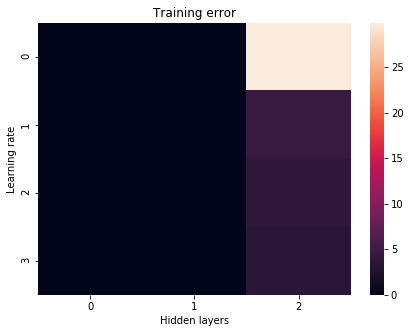

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
fig = sns.heatmap(test_error_storage)
#fig.set_yticks()
fig.set_xlabel('Hidden layers')
fig.set_ylabel('Learning rate')
fig.set_title('Training error')
plt.show()

In [32]:
test_error_storage

array([[ 0.  ,  0.  , 29.82],
       [ 0.  ,  0.  ,  4.44],
       [ 0.  ,  0.  ,  3.9 ],
       [ 0.  ,  0.  ,  3.42]])

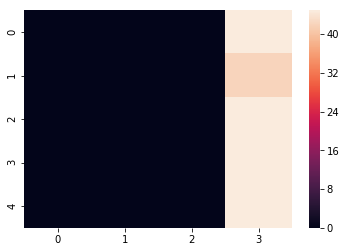

In [105]:
ax = sns.heatmap(train_error_storage)

In [104]:
train_error_storage

array([[ 0. ,  0. ,  0. , 44.9],
       [ 0. ,  0. ,  0. , 42.1],
       [ 0. ,  0. ,  0. , 44.9],
       [ 0. ,  0. ,  0. , 44.9],
       [ 0. ,  0. ,  0. , 44.9]])

In [103]:
test_error_storage

array([[ 0.  ,  0.  ,  0.  , 47.4 ],
       [ 0.  ,  0.  ,  0.  , 44.31],
       [ 0.  ,  0.  ,  0.  , 47.4 ],
       [ 0.  ,  0.  ,  0.  , 47.4 ],
       [ 0.  ,  0.  ,  0.  , 47.4 ]])